In [3]:
import sys
from pathlib import Path

# Add project root to path for imports
NOTEBOOK_DIR = Path.cwd()
PROJECT_ROOT = NOTEBOOK_DIR.parent if NOTEBOOK_DIR.name == "notebooks" else NOTEBOOK_DIR
sys.path.insert(0, str(PROJECT_ROOT))

import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader

from polyquant.data.datasets.sequence_dataset import MarketWindowDataset  # the file we wrote earlier

# Use path relative to notebook location
INDEX_PATH = str(PROJECT_ROOT / "data" / "sequences" / "index.parquet")

SPLIT = "train"
L = 512
CAP = 8192
BATCH_SIZE = 32
NUM_WORKERS = 2  # on Windows 0/2/4; 2 is often good

In [4]:
ds = MarketWindowDataset(
    index_path=INDEX_PATH,
    split=SPLIT,
    L=L,
    cap_trades=CAP,
    min_prefix=20,
    pf_cache=64,
    include_ts=False,   # keep False unless you want timestamp as an extra feature
)

dl = DataLoader(
    ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    persistent_workers=(NUM_WORKERS > 0),
    drop_last=True,
)

print("num markets:", len(ds))


num markets: 97068


In [5]:
x, u, mask, y = next(iter(dl))

print("x:", x.shape, x.dtype)        # (B, L, D)
print("u:", u.shape, u.dtype)        # (B, L)
print("mask:", mask.shape, mask.dtype)
print("y:", y.shape, y.dtype)

assert torch.isfinite(x).all(), "NaN/Inf in x"
assert mask.any(dim=1).all(), "Some samples are fully padded"

# Padded region should be zeros (x,u) by construction
pad_positions = ~mask
assert (x[pad_positions] == 0).all(), "Non-zero x in padded region"
assert (u[pad_positions] == 0).all(), "Non-zero u in padded region"

# Basic range checks on non-pad tokens
xp = x[mask].view(-1, x.shape[-1])

p_yes = xp[:, 0]
dp    = xp[:, 1]

print("p_yes min/max:", float(p_yes.min()), float(p_yes.max()))
print("dp min/max:", float(dp.min()), float(dp.max()))

assert (p_yes >= -1e-3).all() and (p_yes <= 1 + 1e-3).all(), "p_yes out of [0,1]"
assert (dp >= -0.2001).all() and (dp <= 0.2001).all(), "dp outside clip range"

print("OK")


x: torch.Size([32, 512, 10]) torch.float32
u: torch.Size([32, 512]) torch.int64
mask: torch.Size([32, 512]) torch.bool
y: torch.Size([32]) torch.int64
p_yes min/max: 0.05000000074505806 0.9990000128746033
dp min/max: -0.20000000298023224 0.20000000298023224
OK


label y = 1 sequence length = 137


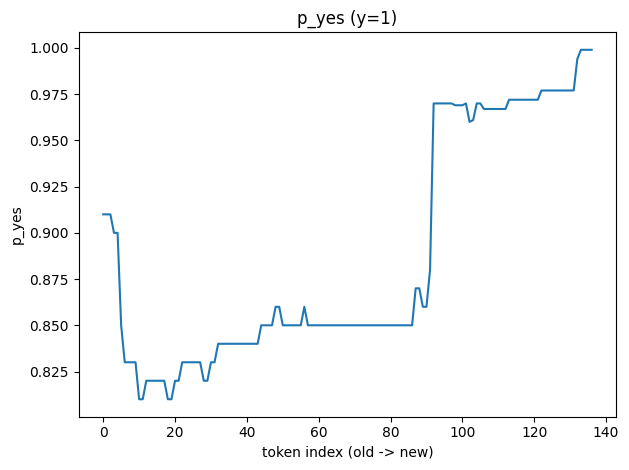

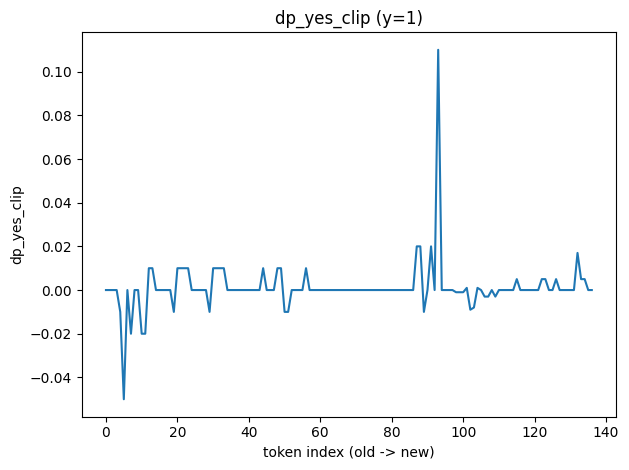

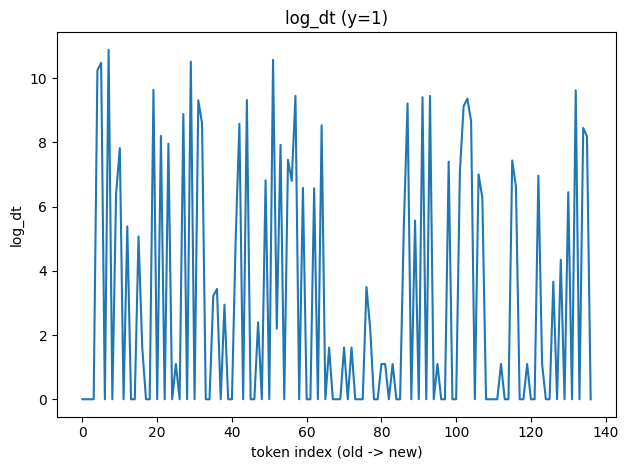

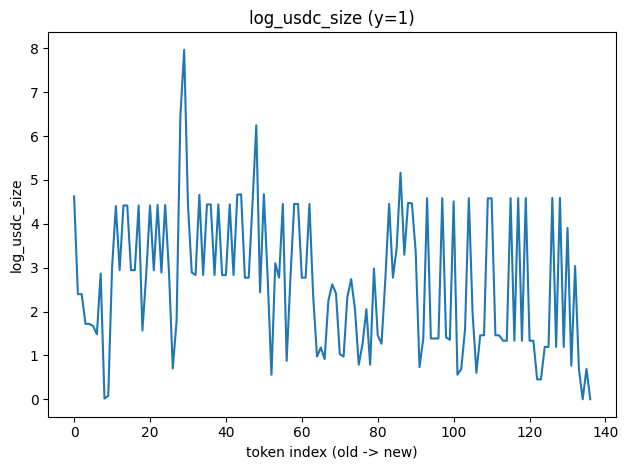

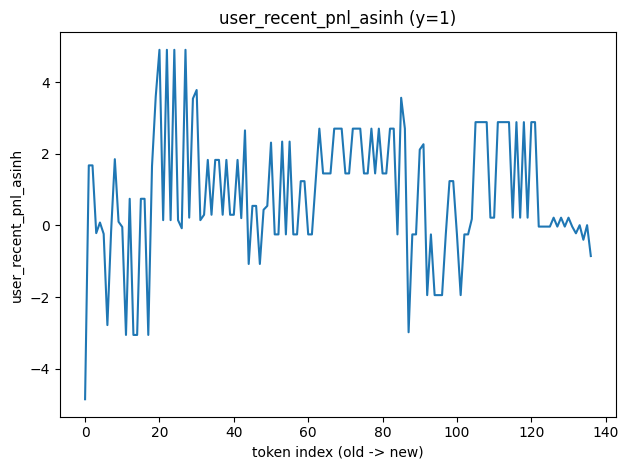

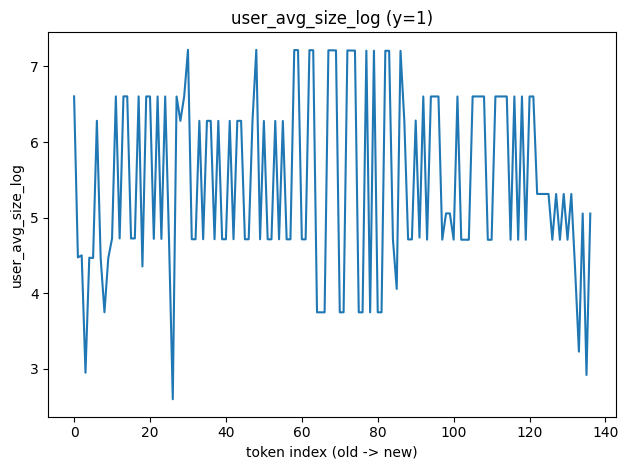

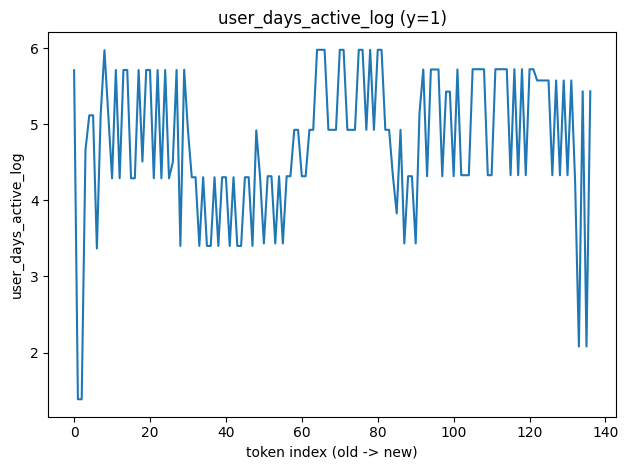

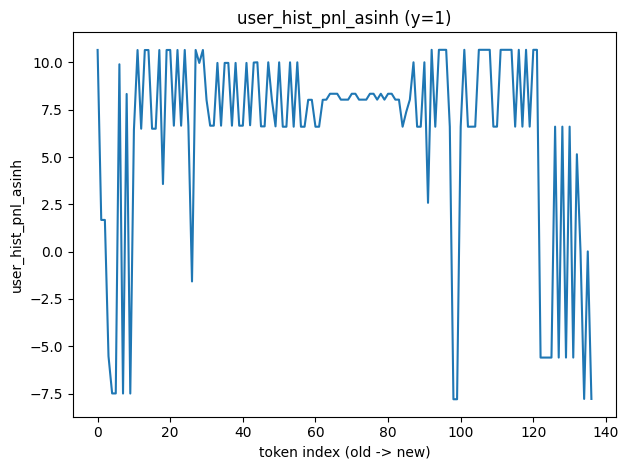

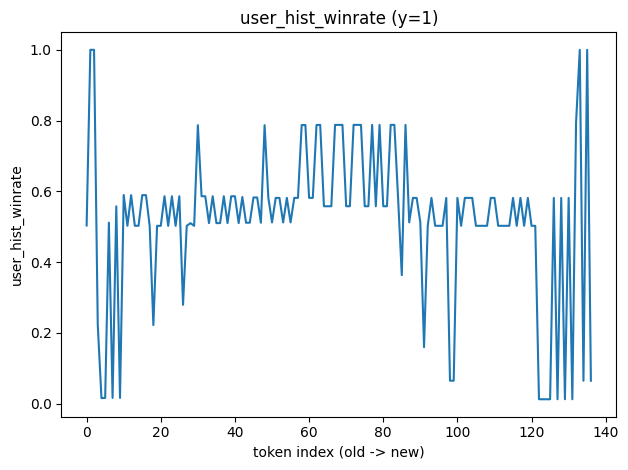

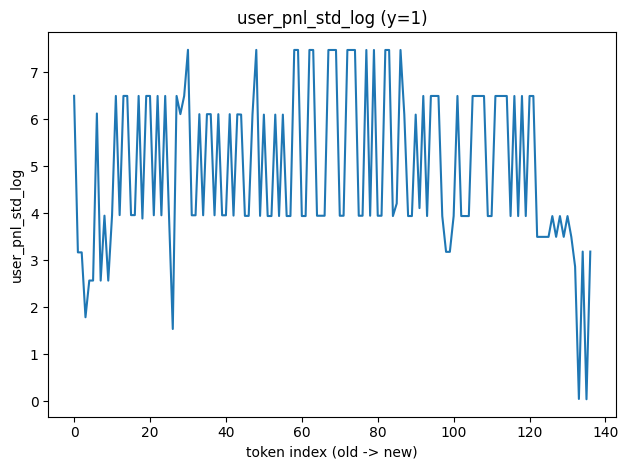

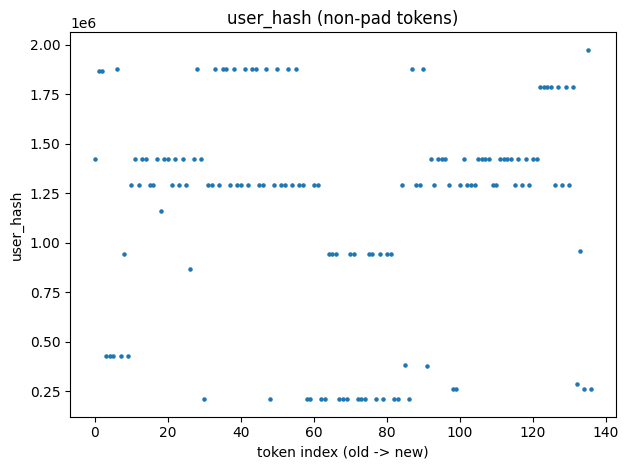

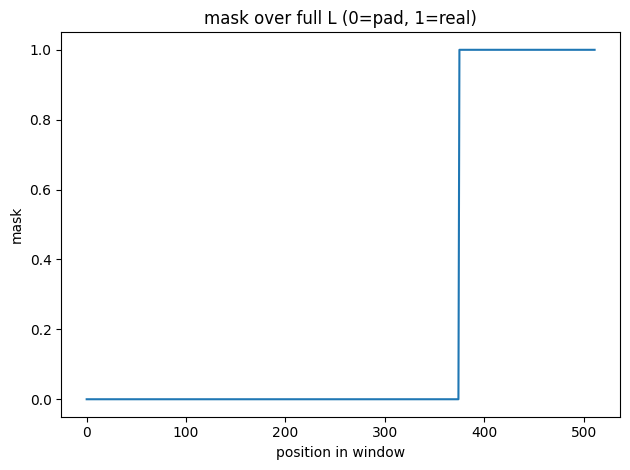

In [6]:
feature_names = [
    "p_yes",
    "dp_yes_clip",
    "log_dt",
    "log_usdc_size",
    "user_recent_pnl_asinh",
    "user_avg_size_log",
    "user_days_active_log",
    "user_hist_pnl_asinh",
    "user_hist_winrate",
    "user_pnl_std_log",
]

i = 0  # pick sample in batch
xi = x[i].cpu().numpy()         # (L, D)
ui = u[i].cpu().numpy()         # (L,)
mi = mask[i].cpu().numpy()      # (L,)
yi = int(y[i].item())

# Keep only real tokens
xr = xi[mi]
ur = ui[mi]
t = np.arange(len(xr))

print("label y =", yi, "sequence length =", len(xr))

# Plot each feature
for k, name in enumerate(feature_names[: xr.shape[1]]):
    plt.figure()
    plt.plot(t, xr[:, k])
    plt.title(f"{name} (y={yi})")
    plt.xlabel("token index (old -> new)")
    plt.ylabel(name)
    plt.tight_layout()
    plt.show()

# Plot user_hash as scatter (just to see dynamics)
plt.figure()
plt.scatter(t, ur, s=5)
plt.title("user_hash (non-pad tokens)")
plt.xlabel("token index (old -> new)")
plt.ylabel("user_hash")
plt.tight_layout()
plt.show()

# Plot mask itself (should be all ones here because we already filtered)
plt.figure()
plt.plot(mi.astype(int))
plt.title("mask over full L (0=pad, 1=real)")
plt.xlabel("position in window")
plt.ylabel("mask")
plt.tight_layout()
plt.show()


In [10]:
xp = x[mask].view(-1, x.shape[-1]).cpu().numpy()

def qstats(a):
    return np.quantile(a, [0.001, 0.01, 0.5, 0.99, 0.999])

for k, name in enumerate(feature_names[: xp.shape[1]]):
    qs = qstats(xp[:, k])
    print(name, "quantiles:", qs.tolist())

# label balance in this batch
print("batch y mean:", float(y.float().mean()))


p_yes quantiles: [0.019999999552965164, 0.06000000238418579, 0.699999988079071, 0.9990000128746033, 0.9990000128746033]
dp_yes_clip quantiles: [-0.20000000298023224, -0.11999999731779099, 0.0, 0.10000000149011612, 0.20000000298023224]
log_dt quantiles: [0.0, 0.0, 0.0, 10.962083854675289, 12.69914233398443]
log_usdc_size quantiles: [0.004418504118453711, 0.010309869609773158, 2.1590993404388428, 7.046026291847198, 8.334955632209782]
user_recent_pnl_asinh quantiles: [-6.286642372131348, -5.463271617889404, -0.0033999935258179903, 5.3392533016204755, 6.434964179992676]
user_avg_size_log quantiles: [0.0, 0.0, 4.429333448410034, 7.6621818065643295, 8.427850784301805]
user_days_active_log quantiles: [0.6931471824645996, 0.6931471824645996, 3.6635615825653076, 5.937536239624023, 6.2045578956604]
user_hist_pnl_asinh quantiles: [-10.145272254943848, -8.71460247039795, 2.7324172258377075, 10.523366928100586, 10.523366928100586]
user_hist_winrate quantiles: [0.0, 0.0, 0.49613258242607117, 1.0, 1.